### Input initial parameter

In [163]:
samples=40
no_bins=4 #bins = (1,2,,,n_bins-1)
n_cov=4

### Create random matrix 

In [164]:
import numpy as np
mat=np.random.random((samples,n_cov))*10

In [165]:
def create_bins_array(initial_mat,no_bins,n_cov):
    bmat=np.zeros((len(initial_mat),len(initial_mat[0])))
    bins=np.linspace(0,10,no_bins)
    for b in range(n_cov):
        data=initial_mat[:,b]
        digitized=np.digitize(data,bins)
        bmat[:,b]=digitized
    return bmat

### Create bin matrix

In [166]:
bins=create_bins_array(mat,no_bins,n_cov)
print(bins)

[[3. 3. 2. 2.]
 [3. 1. 2. 1.]
 [2. 3. 1. 1.]
 [1. 3. 3. 3.]
 [1. 1. 3. 2.]
 [2. 2. 1. 2.]
 [1. 1. 1. 2.]
 [3. 2. 2. 3.]
 [3. 1. 2. 2.]
 [1. 2. 1. 3.]
 [3. 1. 3. 1.]
 [1. 3. 2. 3.]
 [3. 3. 1. 1.]
 [2. 2. 1. 1.]
 [2. 3. 3. 3.]
 [3. 3. 2. 1.]
 [1. 3. 3. 3.]
 [1. 3. 2. 3.]
 [1. 2. 2. 2.]
 [1. 3. 1. 1.]
 [2. 3. 3. 2.]
 [2. 2. 1. 2.]
 [2. 2. 1. 1.]
 [2. 3. 2. 3.]
 [1. 2. 2. 1.]
 [2. 2. 1. 2.]
 [3. 1. 2. 2.]
 [1. 2. 3. 2.]
 [1. 3. 1. 3.]
 [2. 3. 1. 1.]
 [2. 3. 2. 2.]
 [2. 2. 2. 3.]
 [3. 1. 1. 1.]
 [1. 1. 3. 1.]
 [2. 2. 3. 1.]
 [1. 2. 1. 1.]
 [3. 3. 2. 1.]
 [2. 1. 3. 2.]
 [2. 2. 2. 1.]
 [1. 3. 1. 1.]]


### Model Formulation

In [167]:
from pyqubo import Array,Constraint
s=Array.create('s',shape=samples,vartype='SPIN')

def objective_function(s,bins,no_bins):
    H=0
    for col in range(len(mat[0])):
        for b in range(1,no_bins+1):
            M=0
            for val,ss in zip(bins[:,col],s):
                if val==b:
                    M=M+ss
            H=H+(M-0)**2
    return H-0

H=(objective_function(s,bins,no_bins))
#M=4
#con=sum(ss for ss in s)**2
#H=H-M*Constraint(con,label='q-1')
model=H.compile()
qubo,offset=model.to_qubo()
bqm=model.to_dimod_bqm()

### QUBO matrix

In [168]:
import re
qmat=np.zeros((samples,samples))
for key,val in qubo.items():
    x=int(int(re.search(r'\d+', key[0]).group()))
    y=int(int(re.search(r'\d+', key[1]).group()))
    qmat[min(x,y)][max(x,y)]=val

import pandas as pd
q=pd.DataFrame(qmat)
print(q)

       0      1      2      3      4      5      6      7      8      9   \
0  -204.0   16.0    8.0    8.0    8.0    8.0    8.0   16.0   24.0    0.0   
1     0.0 -188.0    8.0    0.0    8.0    0.0    8.0   16.0   24.0    0.0   
2     0.0    0.0 -240.0    8.0    0.0   16.0    8.0    0.0    0.0    8.0   
3     0.0    0.0    0.0 -192.0   16.0    0.0    8.0    8.0    0.0   16.0   
4     0.0    0.0    0.0    0.0 -172.0    8.0   24.0    0.0   16.0    8.0   
5     0.0    0.0    0.0    0.0    0.0 -212.0   16.0    8.0    8.0   16.0   
6     0.0    0.0    0.0    0.0    0.0    0.0 -192.0    0.0   16.0   16.0   
7     0.0    0.0    0.0    0.0    0.0    0.0    0.0 -180.0   16.0   16.0   
8     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0 -172.0    0.0   
9     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0 -200.0   
10    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12    0.0   

### Optimization 

In [169]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import neal
sampler=EmbeddingComposite(DWaveSampler())
sampler=neal.SimulatedAnnealingSampler()
response=sampler.sample(bqm,num_reads=100)

### Select one of the result that gives minimum energy as the answer to this problem

In [170]:
from collections import defaultdict    
result=defaultdict(list)
for r in response.data(['sample', 'energy']):
    result[r.energy].append(r.sample)

res=pd.DataFrame()
min_energy=min(result.keys())
for i in list(result[min_energy]):
    temp=pd.DataFrame.from_dict(i,'index').transpose()
    res=res.append(temp)
res=res.drop_duplicates()

In [171]:
res=res.drop_duplicates()
print(res)

    s[0]  s[10]  s[11]  s[12]  s[13]  s[14]  s[15]  s[16]  s[17]  s[18]  ...   \
0      1      0      0      0      0      0      0      1      1      0  ...    
0      1      0      0      1      1      1      0      0      1      0  ...    
0      1      1      1      0      1      0      0      0      0      0  ...    
0      0      1      1      1      1      1      1      0      0      1  ...    
0      1      1      0      0      0      1      0      1      1      1  ...    
0      0      0      0      1      0      0      0      1      1      0  ...    
0      0      1      0      1      0      0      1      0      0      0  ...    
0      0      0      0      0      0      0      0      0      1      0  ...    
0      1      0      0      1      1      0      0      1      0      0  ...    
0      0      0      1      1      0      1      0      0      1      0  ...    
0      0      0      1      0      1      0      1      1      1      0  ...    
0      0      1      0      

### Visualize no. differences by covariate and bin

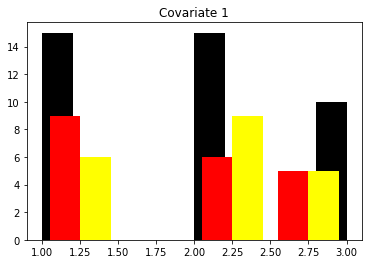

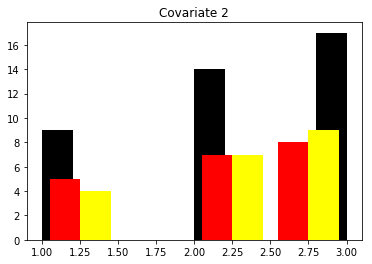

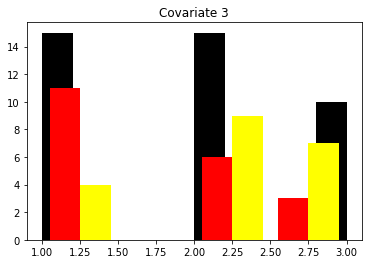

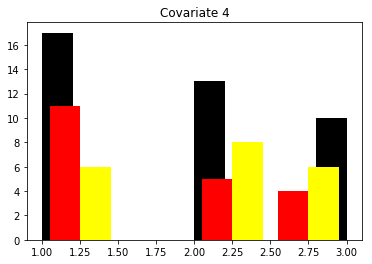

In [172]:
import matplotlib.pyplot as plt
group=pd.DataFrame(res.iloc[0,:]).reset_index().drop('index',axis=1).rename({0:'group'},axis=1)

colors=['red','yellow']
for i in range(n_cov):
    cov=pd.DataFrame(bins[:,i]).rename({0:'bins'},axis=1)
    df=pd.concat([cov, group], axis=1)
    plt.title('Overall data binning')
    plt.hist(list(df['bins']),density=False,histtype='bar',color='black')
    plt.title('Covariate '+str(i+1))
    plt.hist([list(df[df['group']==0]['bins']),list(df[df['group']==1]['bins'])],density=False,histtype='bar',color=colors,bins=no_bins)
    plt.show()

### Calculate means difference between groups

In [173]:
##########Variance, mean (Compare with randomization technique)##################################
dcov=dict()
group=pd.DataFrame(res.iloc[0,:]).reset_index().drop('index',axis=1).rename({0:'group'},axis=1)
for i in range(n_cov):
    cov=pd.DataFrame(mat[:,i]).rename({0:'bins'},axis=1)
    df=pd.concat([cov, group], axis=1)
    dcov[i]={'mean':df['bins'].mean(),
            'variance':df['bins'].var(),
            'mean_control':df[df['group']==0]['bins'].mean(),
            'variance_control':df[df['group']==0]['bins'].var(),
            'mean_treatment':df[df['group']==1]['bins'].mean(),
            'variance_treatment':df[df['group']==1]['bins'].var()}
#print(pd.DataFrame.from_dict(dcov))
#randomization
group=pd.DataFrame(np.random.randint(0,2,(samples,1))).rename({0:'group'},axis=1)
dcovrand=dict()
for i in range(n_cov):
    cov=pd.DataFrame(mat[:,i]).rename({0:'bins'},axis=1)
    df=pd.concat([cov, group], axis=1)
    dcovrand[i]={'mean':df['bins'].mean(),
            'variance':df['bins'].var(),
            'mean_control':df[df['group']==0]['bins'].mean(),
            'variance_control':df[df['group']==0]['bins'].var(),
            'mean_treatment':df[df['group']==1]['bins'].mean(),
            'variance_treatment':df[df['group']==1]['bins'].var()}
#print(pd.DataFrame.from_dict(dcovrand))


In [176]:
df=pd.DataFrame.from_dict(dcov).transpose()
df['different of means-optimization']=(df['mean_treatment']-df['mean_control']).abs()
df_rand=pd.DataFrame.from_dict(dcovrand).transpose()
df_rand['different of means-before optimization']=(df_rand['mean_treatment']-df_rand['mean_control']).abs()
result = pd.concat([df_rand['different of means-before optimization'],df['different of means-optimization']], axis=1, sort=False)

print(result.mean())

different of means-before optimization    1.064594
different of means-optimization           0.673086
dtype: float64
